### Question 5: Implementation of stochastic volatility models

##### Part 1: PDE (Black & Scholes) discretization.
We remind the following BS PDE/model:
$$
dS_t = r S_t dt + \sigma S_t dB_t
$$
Its solution is given by:
$$
S_t = e^{(r-\frac{\sigma^2}{2})t + \sigma B_t}
$$

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

class BS_price_simul:
    def __init__(self, S0, r, sigma, method='Euler'):
        self.r = r
        self.sigma = sigma
        self.S0 = S0
        self.method = method
        if self.method not in ('Euler', 'Milstein'):
            raise ValueError('Method not supported, please choose Euler or Milstein')
        self.simulation = None
        self.true_values = None
        self.nb_simul = None
        self.nb_points = None
        self.T = None

        self.strong_error = None
        self.weak_error = None
        
    def get_value(self, S, t, Z):
        return S * np.exp((self.r - 0.5 * self.sigma**2) * t + self.sigma * np.sqrt(t) * Z)
    
    def simulate(self, T, nb_simul, nb_points):
        
        self.nb_simul = nb_simul
        self.nb_points = nb_points
        self.T = T
        
        #init for St values
        self.simulation = np.zeros((nb_simul, nb_points + 1)) # +1 because S_0, ... , S_T
        self.simulation[:,0] = self.S0 #same init for all simulations
        self.true_values = np.zeros((nb_simul, nb_points + 1))
        self.true_values[:,0] = self.S0
        
        if self.method == 'Milstein':
            def method(S, dt, dZ):
                return self.r * S * dt + self.sigma * S * np.sqrt(dt) * dZ + 0.5 * self.sigma**2 * S * dt * (dZ**2 - 1)

        else:
            def method(S, dt, dZ):
                return self.r * S * dt + self.sigma * S * np.sqrt(dt) * dZ
            
        dt = T/nb_points
        for simul in range(nb_simul):
            for step in range(1, nb_points + 1):
                dZ = np.random.normal(0, 1)
                self.simulation[simul, step] = self.simulation[simul, step - 1] + method(self.simulation[simul, step - 1], dt, dZ)
                self.true_values[simul, step] = self.get_value(self.true_values[simul, step - 1], dt, dZ)
                
        return "Simulations completed"
    
    def get_errors(self, f=lambda x: x):
        errors = self.simulation - self.true_values
        self.strong_error = np.mean(np.abs(errors[:, -1]))
        self.weak_error = np.abs(np.mean(f(self.simulation[:, -1])) - np.mean(f(self.true_values[:, -1])))

    def plot_paths(self, num_paths=5):
        if self.simulation is None:
            raise ValueError("Run the simulate() method before plotting paths.")
        
        plt.figure(figsize=(10, 6))
        for i in range(min(num_paths, self.nb_simul)):
            plt.plot(np.linspace(0, 1, self.nb_points + 1), self.simulation[i, :], label=f'Simulation {i+1}')
        plt.xlabel('Time')
        plt.ylabel('Stock Price')
        plt.title(f'Simulated GBM paths using {self.method} method')
        plt.legend()
        plt.show()

In [6]:
## evaluation of the convergence orders 
#valeurs en dur
nb_simulations = 10000
nb_points = [5,10,20,50,75,100,200,500]
strong_errors_euler = []
strong_errors_milstein = []
weak_errors_euler = []
weak_errors_milstein = []   
S0=100
r=0.03
sigma=0.1
T=1
K = 100
v_bar=0.03

In [3]:
# strong error
def f(x):
    return x

for nb_pt in nb_points:    
    model_euler = BS_price_simul(S0=S0, r=r, sigma=sigma, method='Euler')
    model_milstein = BS_price_simul(S0=S0, r=r, sigma=sigma,method='Milstein')
    
    model_euler.simulate(T=1, nb_simul=nb_simulations, nb_points=nb_pt)
    model_milstein.simulate(T=1, nb_simul=nb_simulations, nb_points=nb_pt)
    
    model_euler.get_errors(f=f)
    model_milstein.get_errors(f=f)
    
    strong_errors_euler.append(model_euler.strong_error)
    strong_errors_milstein.append(model_milstein.strong_error)
    
    weak_errors_euler.append(model_euler.weak_error)
    weak_errors_milstein.append(model_milstein.weak_error)
    print(f'{nb_pt} is done!')
    

5 is done!
10 is done!
20 is done!
50 is done!
75 is done!
100 is done!
200 is done!
500 is done!


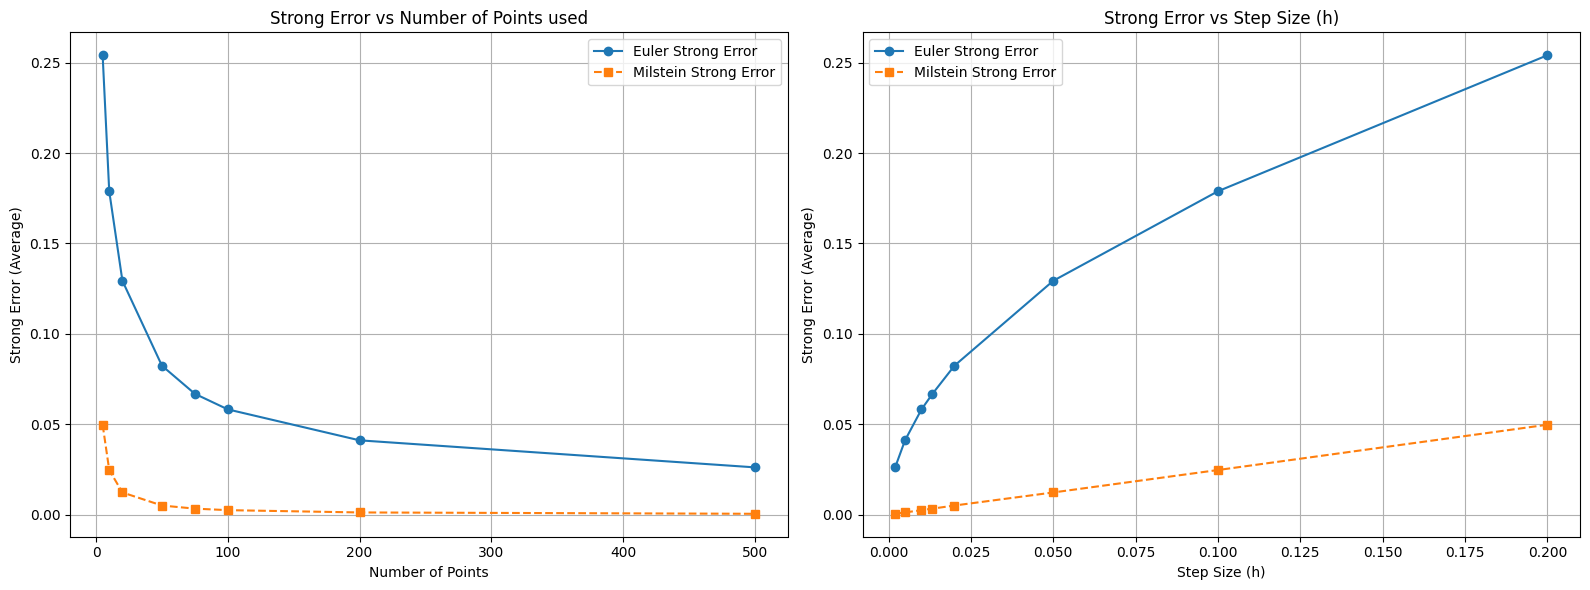

In [4]:
# Plot strong errors
h_values = [model_euler.T / nb for nb in nb_points]  # Calculate step size h

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

axes[0].plot(nb_points, strong_errors_euler, label='Euler Strong Error', marker='o', linestyle='-')
axes[0].plot(nb_points, strong_errors_milstein, label='Milstein Strong Error', marker='s', linestyle='--')
axes[0].set_xlabel('Number of Points')
axes[0].set_ylabel('Strong Error (Average)')
axes[0].set_title('Strong Error vs Number of Points used')
axes[0].legend()
axes[0].grid(True)

# Plot strong error as a function of step size (h)
axes[1].plot(h_values, strong_errors_euler, label='Euler Strong Error', marker='o', linestyle='-')
axes[1].plot(h_values, strong_errors_milstein, label='Milstein Strong Error', marker='s', linestyle='--')
axes[1].set_xlabel('Step Size (h)')
axes[1].set_ylabel('Strong Error (Average)')
axes[1].set_title('Strong Error vs Step Size (h)')
axes[1].legend()
axes[1].grid(True)

# Display the plots
plt.tight_layout()
plt.show()

comments: we find the orders expected in h (resp 0.5 and 1).

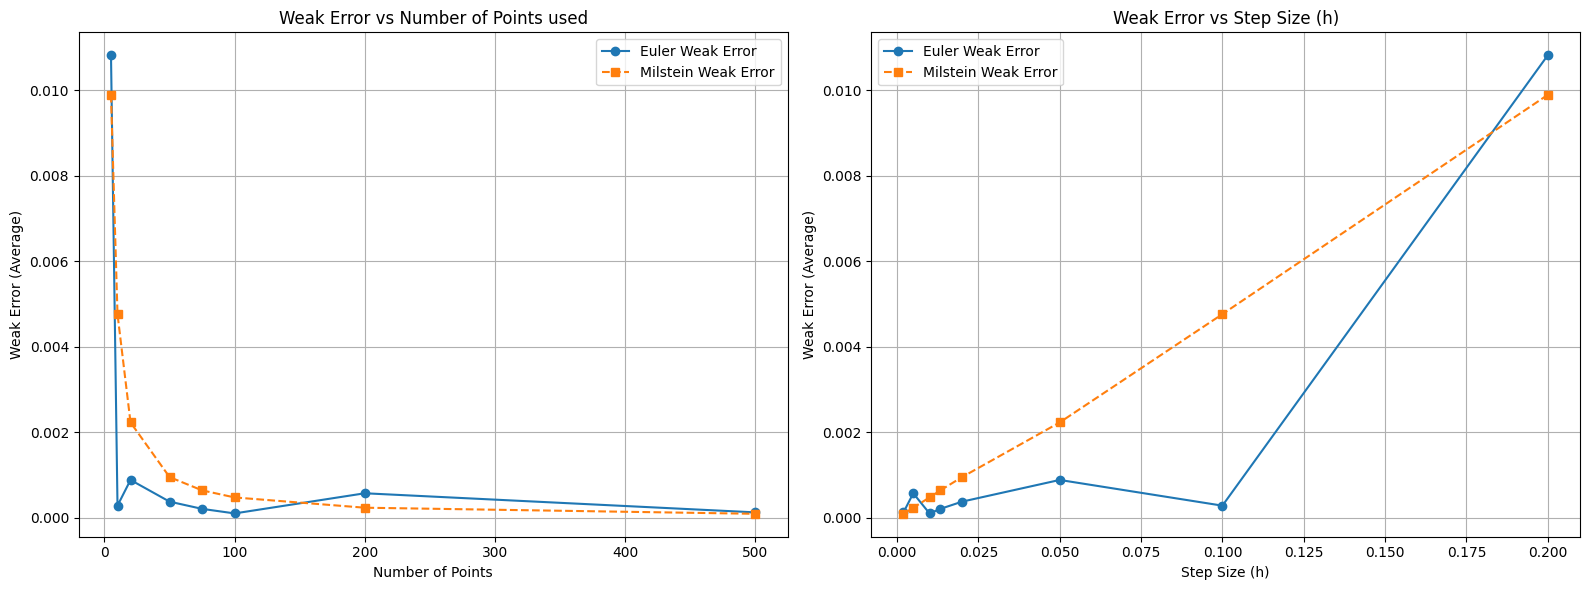

In [5]:
# Plot weak errors
h_values = [model_euler.T / nb for nb in nb_points]  # Calculate step size h

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

axes[0].plot(nb_points, weak_errors_euler, label='Euler Weak Error', marker='o', linestyle='-')
axes[0].plot(nb_points, weak_errors_milstein, label='Milstein Weak Error', marker='s', linestyle='--')
axes[0].set_xlabel('Number of Points')
axes[0].set_ylabel('Weak Error (Average)')
axes[0].set_title('Weak Error vs Number of Points used')
axes[0].legend()
axes[0].grid(True)

# Plot strong error as a function of step size (h)
axes[1].plot(h_values, weak_errors_euler, label='Euler Weak Error', marker='o', linestyle='-')
axes[1].plot(h_values, weak_errors_milstein, label='Milstein Weak Error', marker='s', linestyle='--')
axes[1].set_xlabel('Step Size (h)')
axes[1].set_ylabel('Weak Error (Average)')
axes[1].set_title('Weak Error vs Step Size (h)')
axes[1].legend()
axes[1].grid(True)
plt.tight_layout()
plt.show()

comments: we find the good orders (1 in both cases), but need more simulation points for convergence of the expected values of errors in the Euler case. We let it as it is to avoid long computations for the moment.

##### Part 2: Monte Carlo pricing, Heston model

- **Heston model:**

  $$
  \begin{cases}
  dS_t = rS_t dt + \sqrt{v_t} S_t dB_t^1, \\
  dv_t = -\lambda(v_t - \bar{v}) dt + \eta \sqrt{v_t} dB_t^2,
  \end{cases}
  $$

  with $\langle B_1, B_2 \rangle_t = \rho t$, $\rho \in ]-1, 1[$.

- **Using log prices, $X_t = \log(S_t)$:**

  $$
  \begin{cases}
  dX_t = \left(r - \frac{v_t}{2}\right) dt + \sqrt{v_t} dB_t^1, \\
  dv_t = -\lambda(v_t - \bar{v}) dt + \eta \sqrt{v_t} dB_t^2.
  \end{cases}
  $$

- $v$ is imposed boundary conditions, as it can be negative with positive probability...

In [11]:
class Heston_pricer:
    def __init__(self, r=0.05, lamb=3, eta=0.2, v_bar=0.03, rho=-0.3): # rho often negative on markets...
        self.r = r
        self.lamb = lamb
        self.eta = eta
        self.v_bar = v_bar
        self.log_prices = None  
        self.volatilities = None
        self.rho = rho
        
    def generate_noise(self):
        mean = [0, 0]
        cov = [[1, self.rho],  
               [self.rho, 1]]          
        samples = np.random.multivariate_normal(mean, cov, size=1)
        Z1, Z2 = samples[0] 
        return Z1, Z2
    
    def price_call(self, S, v, K, T, nb_simul=1000, nb_points=1000):
        final_prices = np.zeros(nb_simul)
        dt = T/nb_points

        for simul in range(nb_simul):
            log_price = np.log(S)
            vol = v
            for step in range(1, nb_points + 1): # we use Euler discretization
                dZ1, dZ2 = self.generate_noise()

                log_price += (self.r - 0.5 * vol) * dt + np.sqrt(vol) * np.sqrt(dt) * dZ1
                # absorbing boundary in case v is negative (we take v+)  
                vol = max(0, vol - self.lamb * (vol - self.v_bar) * dt + self.eta * np.sqrt(vol) * dZ2)
                
            final_prices[simul] = np.exp(log_price)

        return np.mean(np.maximum(final_prices - K, 0))

In [8]:
lamb=3 
eta=0.2
rho=-0.5
nb_simulations = 2000
nb_points = 200
T=0.2
nb_prices = 10

In [51]:
heston_pricer = Heston_pricer(r=r, lamb=lamb, eta=eta, v_bar=v_bar, rho=rho)
## !!Warning!! execution time: 10min with nb_simulations = 2000, nb_points = 200
stock_prices = np.linspace(0.8*K, 1.2*K, nb_prices)
payoff = np.maximum(stock_prices - K, 0)
x = max(len(stock_prices) // 100,1)
option_prices = []
for k in range(len(stock_prices)):
    if k % x == 0:
        print(f"\rProgress: {k / len(stock_prices):.0%}", end="")  
    option_prices.append(heston_pricer.price_call(S=stock_prices[k],v=v_bar,K=K, T=T,nb_simul=nb_simulations, nb_points=nb_points))
print(f"\rProgress: {1 / 1:.0%}", end="")  

Progress: 100%

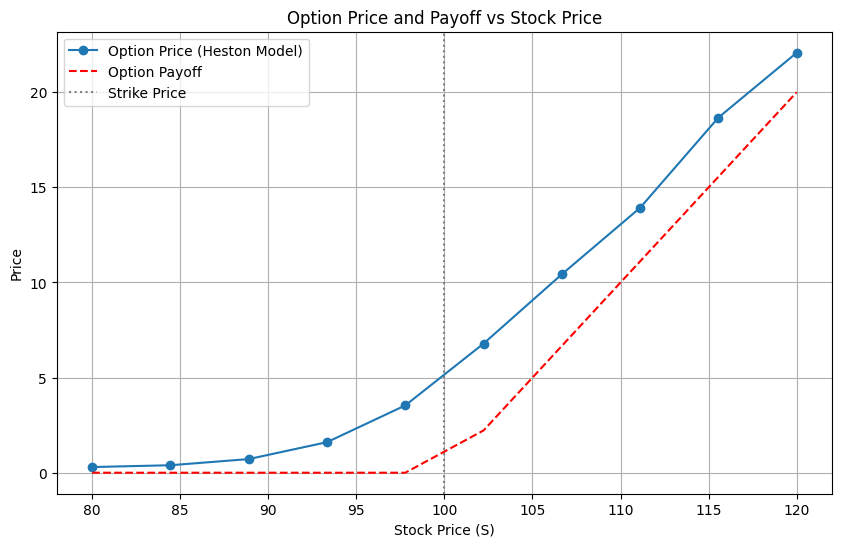

In [52]:
plt.figure(figsize=(10, 6))
plt.plot(stock_prices, option_prices, label="Option Price (Heston Model)", marker="o")
plt.plot(stock_prices, payoff, label="Option Payoff", linestyle="--", color="red")
plt.axvline(K, color="gray", linestyle=":", label="Strike Price")
plt.title("Option Price and Payoff vs Stock Price")
plt.xlabel("Stock Price (S)")
plt.ylabel("Price")
plt.legend()
plt.grid()
plt.show()

In [12]:
def black_scholes_european_call(S=100, K=100, T=1, r=0.05, sigma=0.2):
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    return S * stats.norm.cdf(d1) - K * np.exp(-r * T) * stats.norm.cdf(d2)

def IV_Call(price,S ,T ,K, r=r, eps=1e-10):
    x0=0;x1=1
    while (x1-x0)/2 > eps:
        x_mid = (x0 + x1) / 2
        sigma = x_mid / (1 - x_mid)
        price_estimate = black_scholes_european_call(S,K,T,r,sigma)
        if price_estimate == price:
            return sigma
        elif price_estimate > price:
            x1 = x_mid
        else :
            x0 = x_mid
    return sigma

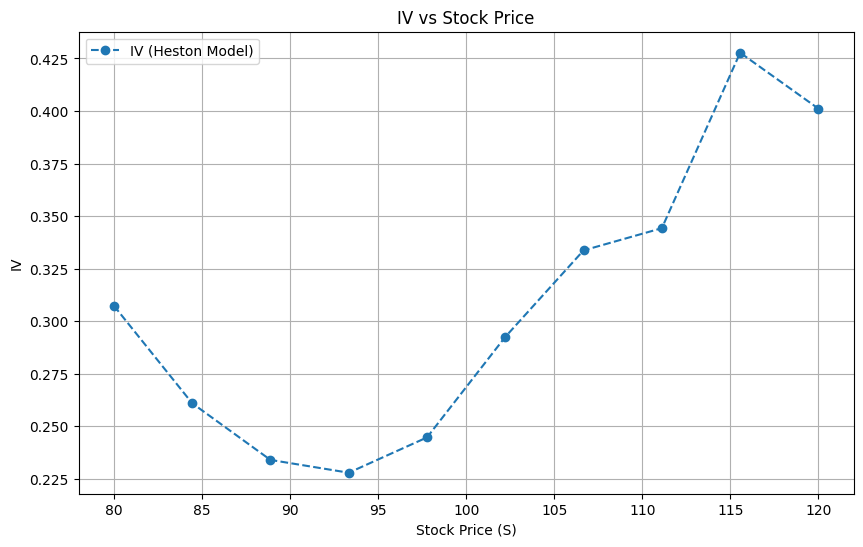

In [59]:
IV_Heston = []
for option_price, stock_price in zip(option_prices,stock_prices):
    IV_Heston.append(IV_Call(price=option_price,S=stock_price,T=T,K=K,r=r))

plt.figure(figsize=(10, 6))
plt.plot(stock_prices, IV_Heston, label="IV (Heston Model)", marker="o",linestyle='--')
plt.title("IV vs Stock Price")
plt.xlabel("Stock Price (S)")
plt.ylabel("IV")
plt.legend()
plt.grid()
plt.show()

In [21]:
lambdas=[1,3,5] 
etas=[0.2,0.2,0.2]
rhos=[-0.5,-0.5,-0.5]
nb_simulations = 2000
nb_points = 200
T=0.2
nb_prices = 3

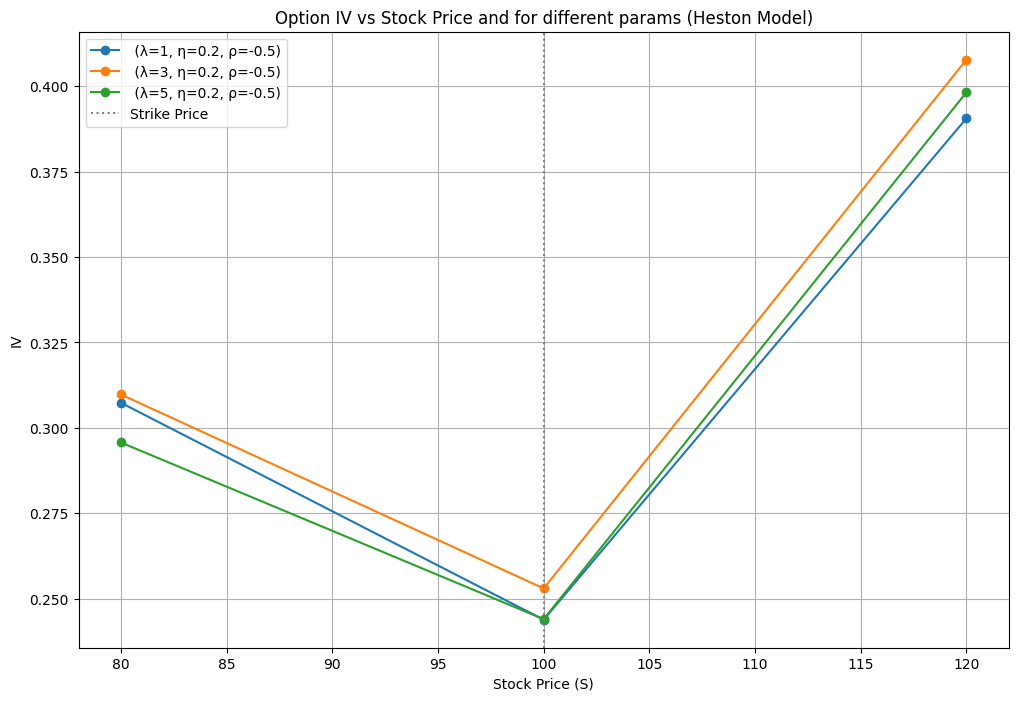

In [22]:
stock_prices = np.linspace(0.8*K, 1.2*K, nb_prices)
payoff = np.maximum(stock_prices - K, 0)
x = max(len(stock_prices) // 100,1)

import numpy as np
import matplotlib.pyplot as plt

stock_prices = np.linspace(0.8 * K, 1.2 * K, nb_prices)
plt.figure(figsize=(12, 8))

for lamb, eta, rho in zip(lambdas, etas, rhos):
    heston_pricer = Heston_pricer(r=r, lamb=lamb, eta=eta, v_bar=v_bar, rho=rho)

    option_prices = []
    for k in range(len(stock_prices)):
          price = heston_pricer.price_call(
            S=stock_prices[k],
            v=v_bar,
            K=K,
            T=T,
            nb_simul=nb_simulations,
            nb_points=nb_points)
          option_prices.append(IV_Call(price=price,S=stock_prices[k],T=T,K=K,r=r))
  
    plt.plot(stock_prices, option_prices, label=f" (\u03bb={lamb}, \u03b7={eta}, \u03c1={rho})", marker="o")


plt.axvline(K, color="gray", linestyle=":", label="Strike Price")

plt.title("Option IV vs Stock Price and for different params (Heston Model)")
plt.xlabel("Stock Price (S)")
plt.ylabel("IV")
plt.legend()
plt.grid()
plt.show()

In [23]:
lambdas=[3,3,3]
etas=[0.1,0.2,0.5]
rhos=[-0.5,-0.5,-0.5]
nb_simulations = 2000
nb_points = 200
T=0.2
nb_prices = 3

In [ ]:
## !!Warning!! execution time: 30min with nb_simulations = 2000, nb_points = 200
stock_prices = np.linspace(0.8*K, 1.2*K, nb_prices)
payoff = np.maximum(stock_prices - K, 0)
x = max(len(stock_prices) // 100,1)

import numpy as np
import matplotlib.pyplot as plt

stock_prices = np.linspace(0.8 * K, 1.2 * K, nb_prices)
plt.figure(figsize=(12, 8))

for lamb, eta, rho in zip(lambdas, etas, rhos):
    heston_pricer = Heston_pricer(r=r, lamb=lamb, eta=eta, v_bar=v_bar, rho=rho)

    option_prices = []
    for k in range(len(stock_prices)):
          price = heston_pricer.price_call(
            S=stock_prices[k],
            v=v_bar,
            K=K,
            T=T,
            nb_simul=nb_simulations,
            nb_points=nb_points)
          option_prices.append(IV_Call(price=price,S=stock_prices[k],T=T,K=K,r=r))
  
    plt.plot(stock_prices, option_prices, label=f" (\u03bb={lamb}, \u03b7={eta}, \u03c1={rho})", marker="o")


plt.axvline(K, color="gray", linestyle=":", label="Strike Price")

plt.title("Option IV vs Stock Price and for different params (Heston Model)")
plt.xlabel("Stock Price (S)")
plt.ylabel("IV")
plt.legend()
plt.grid()
plt.show()

In [ ]:
lambdas=[3,3,3]
etas=[0.2,0.2,0.2]
rhos=[-1,-0.5,-0]
nb_simulations = 2000
nb_points = 200
T=0.2
nb_prices = 3

In [ ]:
## !!Warning!! execution time: 30min with nb_simulations = 2000, nb_points = 200
stock_prices = np.linspace(0.8*K, 1.2*K, nb_prices)
payoff = np.maximum(stock_prices - K, 0)
x = max(len(stock_prices) // 100,1)

import numpy as np
import matplotlib.pyplot as plt

stock_prices = np.linspace(0.8 * K, 1.2 * K, nb_prices)
plt.figure(figsize=(12, 8))

for lamb, eta, rho in zip(lambdas, etas, rhos):
    heston_pricer = Heston_pricer(r=r, lamb=lamb, eta=eta, v_bar=v_bar, rho=rho)

    option_prices = []
    for k in range(len(stock_prices)):
          price = heston_pricer.price_call(
            S=stock_prices[k],
            v=v_bar,
            K=K,
            T=T,
            nb_simul=nb_simulations,
            nb_points=nb_points)
          option_prices.append(IV_Call(price=price,S=stock_prices[k],T=T,K=K,r=r))
  
    plt.plot(stock_prices, option_prices, label=f" (\u03bb={lamb}, \u03b7={eta}, \u03c1={rho})", marker="o")


plt.axvline(K, color="gray", linestyle=":", label="Strike Price")

plt.title("Option IV vs Stock Price and for different params (Heston Model)")
plt.xlabel("Stock Price (S)")
plt.ylabel("IV")
plt.legend()
plt.grid()
plt.show()

Comments: Higher lambda result in faster reversion of the vol, and should be reducing smile curvature. Larger eta means more vol of vol, which should be resulting in more curvature on the smile and rho controls skewedness (rho very negative means more vol when the price drops)
The examples in this code may be difficult or even impossible to interpret clearly as we chose to compute very few cases due to the high computation time